# Factors Affecting Health and Fitness


## Import Countries.csv and clean the DataFrame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as st

# Replace 'filename.csv' with the path to your CSV file
df = pd.read_csv('countries.csv')

# Display the first few rows of the DataFrame
df.head()

,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,https://www.cia.gov/the-world-factbook/countri...,Ahmad Shah DURRANI unified the Pashtun tribes ...,"Southern Asia, north and west of Pakistan, eas...","33 00 N, 65 00 E",Asia,"652,230 sq km","652,230 sq km",0 sq km,almost six times the size of Virginia; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,https://www.cia.gov/the-world-factbook/countri...,By terms of the 1960 Treaty of Establishment t...,"Eastern Mediterranean, peninsula on the southw...","34 37 N, 32 58 E",Middle East,123 sq km,NaN,NaN,"about 0.7 times the size of Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,https://www.cia.gov/the-world-factbook/countri...,Albania declared its independence from the Ott...,"Southeastern Europe, bordering the Adriatic Se...","41 00 N, 20 00 E",Europe,"28,748 sq km","27,398 sq km","1,350 sq km",slightly smaller than Maryland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,https://www.cia.gov/the-world-factbook/countri...,Algeria has known many empires and dynasties s...,"Northern Africa, bordering the Mediterranean S...","28 00 N, 3 00 E",Africa,"2,381,740 sq km","2,381,740 sq km",0 sq km,slightly less than 3.5 times the size of Texas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,https://www.cia.gov/the-world-factbook/countri...,Tutuila was settled by 1000 B.C. and the islan...,"Oceania, group of islands in the South Pacific...","14 20 S, 170 00 W",Oceania,224 sq km,224 sq km,0 sq km,"slightly larger than Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Clear out unnecessary columns
df = df[['Country', 
                             'People and Society: Population', 
                             'People and Society: Median age - total', 
                             'People and Society: Obesity - adult prevalence rate', 
                             'Economy: Real GDP per capita']]
df

,Country,People and Society: Population,People and Society: Median age - total,People and Society: Obesity - adult prevalence rate,Economy: Real GDP per capita
0,Afghanistan,"38,346,720 (2022 est.)",19.5 years,5.5% (2016),"$1,500 (2021 est.)$2,000 (2020 est.)$2,100 (20..."
1,Akrotiri,"(2020) approximately 18,195 on the Sovereign B...",NaN,NaN,NaN
2,Albania,"3,095,344 (2022 est.)",34.3 years,21.7% (2016),"$14,500 (2021 est.)$13,300 (2020 est.)$13,700 ..."
3,Algeria,"44,178,884 (2022 est.)",28.9 years,27.4% (2016),"$11,000 (2021 est.)$10,800 (2020 est.)$11,600 ..."
4,American Samoa,"45,443 (2022 est.)",27.2 years,NaN,"$11,200 (2016 est.)$11,300 (2015 est.)$11,200 ..."
...,...,...,...,...,...
253,West Bank,"3,000,021 (2022 est.)",21.9 years,NaN,"$5,600 (2021 est.)$5,400 (2020 est.)$6,200 (20..."
254,World,"7,905,336,896 (July 2022 est.)",31 years,NaN,"$17,000 (2021 est.)$16,200 (2020 est.)$16,800 ..."
255,Yemen,"30,984,689 (2022 est.)",19.8 years (2018 est.),17.1% (2016),"$2,500 (2017 est.)$2,700 (2016 est.)$3,200 (20..."
256,Zambia,"19,642,123 (2022 est.)",16.9 years,8.1% (2016),"$3,200 (2021 est.)$3,200 (2020 est.)$3,400 (20..."


In [3]:
# Remove parentheses and everything inside them from the "Economy: Real GDP per capita" column
df['Economy: Real GDP per capita'] = df['Economy: Real GDP per capita'].str.replace(r'\(.*\)', '')


# Split each cell into multiple columns using the "$" character as the separator
df_new = df['Economy: Real GDP per capita'].str.split('$', expand=True)

# Keep only the first column containing the desired data and rename the column

df_new = df_new[[0]].rename(columns={0: 'New_Column_Name'})

# Merge the modified column back into the original dataframe
df = pd.concat([df, df_new], axis=1)

# Remove the final column and show the dataframe
countries_df = df.drop(columns=['New_Column_Name'])

countries_df = countries_df.rename(columns={'People and Society: Obesity - adult prevalence rate': 'Obesity Rate in Adults (2016)'})

countries_df['Obesity Rate in Adults (2016)'] = countries_df['Obesity Rate in Adults (2016)'].str.replace('\s*\(\d{4}\)', '', regex=True)




C:\Users\Micha\AppData\Local\Temp\ipykernel_22420\153322526.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Economy: Real GDP per capita'] = df['Economy: Real GDP per capita'].str.replace(r'\(.*\)', '')


In [4]:
countries_df

,Country,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita
0,Afghanistan,"38,346,720 (2022 est.)",19.5 years,5.5%,"$1,500"
1,Akrotiri,"(2020) approximately 18,195 on the Sovereign B...",NaN,NaN,NaN
2,Albania,"3,095,344 (2022 est.)",34.3 years,21.7%,"$14,500"
3,Algeria,"44,178,884 (2022 est.)",28.9 years,27.4%,"$11,000"
4,American Samoa,"45,443 (2022 est.)",27.2 years,NaN,"$11,200"
...,...,...,...,...,...
253,West Bank,"3,000,021 (2022 est.)",21.9 years,NaN,"$5,600"
254,World,"7,905,336,896 (July 2022 est.)",31 years,NaN,"$17,000"
255,Yemen,"30,984,689 (2022 est.)",19.8 years (2018 est.),17.1%,"$2,500"
256,Zambia,"19,642,123 (2022 est.)",16.9 years,8.1%,"$3,200"


## Bring in World Happiness Report

In [5]:
whr21_df = pd.read_csv('world-happiness-report-2021.csv')

whr21_df

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.000,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.700,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.400,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.000,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.400,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512,0.120,3.748,3.276,7.926,0.787,48.700,0.715,-0.131,0.915,2.43,0.451,0.731,0.007,0.405,0.103,0.015,1.800
145,Botswana,Sub-Saharan Africa,3.467,0.074,3.611,3.322,9.782,0.784,59.269,0.824,-0.246,0.801,2.43,1.099,0.724,0.340,0.539,0.027,0.088,0.648
146,Rwanda,Sub-Saharan Africa,3.415,0.068,3.548,3.282,7.676,0.552,61.400,0.897,0.061,0.167,2.43,0.364,0.202,0.407,0.627,0.227,0.493,1.095
147,Zimbabwe,Sub-Saharan Africa,3.145,0.058,3.259,3.030,7.943,0.750,56.201,0.677,-0.047,0.821,2.43,0.457,0.649,0.243,0.359,0.157,0.075,1.205


In [6]:
whr21_df2 = whr21_df[['Country name', 
                      'Healthy life expectancy', 
                      'Ladder score']]

whr21_df2 = whr21_df2.rename(columns={'Country name': 'Country'})

whr21_df2

,Country,Healthy life expectancy,Ladder score
0,Finland,72.000,7.842
1,Denmark,72.700,7.620
2,Switzerland,74.400,7.571
3,Iceland,73.000,7.554
4,Netherlands,72.400,7.464
...,...,...,...
144,Lesotho,48.700,3.512
145,Botswana,59.269,3.467
146,Rwanda,61.400,3.415
147,Zimbabwe,56.201,3.145


## Bring in GymData

In [7]:
gd_df = pd.read_csv('gym_data.csv')

# Display the first few rows of the DataFrame
gd_df.head()

,Country,Total Revenue (USD),Total Number of Gyms,Total Members,Member Penetration Rate,Members Per Gym,Annual Revenue Per Gym,Annual Revenue Per Member
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Denmark,"$427,771,557","1,426","1,098,000",18.90%,769.985975,"$299,980.05",$389.59
2,United Arab Emirates,"$419,100,000",846,"537,313",5.58%,635.121749,"$495,390.07",$779.99
3,Taiwan,"$407,000,000",300,"710,000",2.99%,2366.666667,"$1,356,666.67",$573.24
4,New Zealand,"$405,000,000",690,"650,000",13.60%,942.028985,"$586,956.52",$623.08


In [8]:
gym_data_df = gd_df[['Country', 
                     'Total Number of Gyms', 
                     'Total Members', 
                     'Members Per Gym', 
                     'Annual Revenue Per Member']]

gym_data_df = gym_data_df.dropna()
gym_data_df['Annual Revenue Per Member'] = gym_data_df['Annual Revenue Per Member'].str.replace('$', '').str.replace(',', '').str.strip()
gym_data_df['Annual Revenue Per Member'] = gym_data_df['Annual Revenue Per Member'].astype(float)


gym_data_df

C:\Users\Micha\AppData\Local\Temp\ipykernel_22420\2314076988.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  gym_data_df['Annual Revenue Per Member'] = gym_data_df['Annual Revenue Per Member'].str.replace('$', '').str.replace(',', '').str.strip()


,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member
1,Denmark,"1,426","1,098,000",769.985975,389.59
2,United Arab Emirates,846,"537,313",635.121749,779.99
3,Taiwan,300,"710,000",2366.666667,573.24
4,New Zealand,690,"650,000",942.028985,623.08
5,Hong Kong,180,"430,000",2388.888889,920.93
6,Belgium,900,"882,000",980.000000,445.64
7,Colombia,"1,752","979,000",558.789954,384.07
8,Singapore,200,"320,000",1600.000000,1100.00
9,Ukraine,"1,596","1,270,000",795.739348,260.12
10,Portugal,"1,100","688,000",625.454545,475.27


## Bring in AQI_by_city

In [9]:
AQI_city_df = pd.read_csv('AQI_by_city.csv')

AQI_city_df = AQI_city_df.rename(columns={'2021' : '2021 AQI'})

AQI_city_df

,Rank,City,2021 AQI,JAN(2021),FEB(2021),MAR(2021),APR(2021),MAY(2021),JUN(2021),JUL(2021),AUG(2021),SEP(2021),OCT(2021),NOV(2021),DEC(2021),2020,2019,2018,2017
0,1,"Bhiwadi,India",106.2,145.8,129.8,120.2,125.7,86.5,95.9,55.6,55.4,37.1,91.1,188.6,136.6,95.5,83.4,125.4,-
1,2,"Ghaziabad,India",102.0,199.9,172.2,97.8,86.3,52.9,47.2,35.3,37.6,30.8,89.7,218.3,163,106.6,110.2,135.2,144.6
2,3,"Hotan,China",101.5,-,-,158,91.1,167.4,57.4,70.9,93.2,79.3,126.1,111.5,62.6,110.2,110.1,116,91.9
3,4,"Delhi,India",96.4,183.7,142.2,80.5,72.9,47.4,47.1,35.6,36.9,30.2,73.7,224.1,186.4,84.1,98.6,113.5,108.2
4,5,"Jaunpur,India",95.3,182.2,143.5,91,70,51.1,40.7,33.5,34.2,36.8,75.7,196,195.7,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,6471,"Mornington,Australia",2.4,2,1.9,2.3,2.1,3.2,3.6,4.3,2.1,2.1,1.7,2,1.9,3.2,3.8,3,3.9
6471,6472,"EmuRiver,Australia",2.1,1.9,1.8,2,2.6,3.4,2.6,1.9,2.1,2.2,1.5,1.4,1.5,2.6,2.5,2.6,2.3
6472,6473,"Judbury,Australia",2.0,1.6,1.5,2.1,1.5,4.1,2,2.2,2.2,1.7,1.5,1.4,1.7,2.4,5.7,2.2,1.9
6473,6474,"StHelens,Australia",1.9,1.8,2.1,2,2.4,2.7,1.6,1.6,1.6,1.9,1.6,2.4,1.6,2.4,2.4,2.9,3.3


In [10]:
split_data = AQI_city_df['City'].str.split(',', expand=True)

AQI_city_df.drop('City', axis=1, inplace=True)

# Insert the new columns into the original DataFrame
AQI_city_df.insert(loc=1, column='City', value=split_data[0])
AQI_city_df.insert(loc=2, column='Country', value=split_data[1])


#Rename Column
AQI_city_df

,Rank,City,Country,2021 AQI,JAN(2021),FEB(2021),MAR(2021),APR(2021),MAY(2021),JUN(2021),JUL(2021),AUG(2021),SEP(2021),OCT(2021),NOV(2021),DEC(2021),2020,2019,2018,2017
0,1,Bhiwadi,India,106.2,145.8,129.8,120.2,125.7,86.5,95.9,55.6,55.4,37.1,91.1,188.6,136.6,95.5,83.4,125.4,-
1,2,Ghaziabad,India,102.0,199.9,172.2,97.8,86.3,52.9,47.2,35.3,37.6,30.8,89.7,218.3,163,106.6,110.2,135.2,144.6
2,3,Hotan,China,101.5,-,-,158,91.1,167.4,57.4,70.9,93.2,79.3,126.1,111.5,62.6,110.2,110.1,116,91.9
3,4,Delhi,India,96.4,183.7,142.2,80.5,72.9,47.4,47.1,35.6,36.9,30.2,73.7,224.1,186.4,84.1,98.6,113.5,108.2
4,5,Jaunpur,India,95.3,182.2,143.5,91,70,51.1,40.7,33.5,34.2,36.8,75.7,196,195.7,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,6471,Mornington,Australia,2.4,2,1.9,2.3,2.1,3.2,3.6,4.3,2.1,2.1,1.7,2,1.9,3.2,3.8,3,3.9
6471,6472,EmuRiver,Australia,2.1,1.9,1.8,2,2.6,3.4,2.6,1.9,2.1,2.2,1.5,1.4,1.5,2.6,2.5,2.6,2.3
6472,6473,Judbury,Australia,2.0,1.6,1.5,2.1,1.5,4.1,2,2.2,2.2,1.7,1.5,1.4,1.7,2.4,5.7,2.2,1.9
6473,6474,StHelens,Australia,1.9,1.8,2.1,2,2.4,2.7,1.6,1.6,1.6,1.9,1.6,2.4,1.6,2.4,2.4,2.9,3.3


In [11]:
AQI_city_df2 = AQI_city_df[['City',
                           'Country', 
                           '2021 AQI', 
                     ]]
AQI_city_df2

,City,Country,2021 AQI
0,Bhiwadi,India,106.2
1,Ghaziabad,India,102.0
2,Hotan,China,101.5
3,Delhi,India,96.4
4,Jaunpur,India,95.3
...,...,...,...
6470,Mornington,Australia,2.4
6471,EmuRiver,Australia,2.1
6472,Judbury,Australia,2.0
6473,StHelens,Australia,1.9


In [12]:
# Compute the average AQI for each country
avg_aqi_by_country = AQI_city_df.groupby(['Country'])['2021 AQI'].mean().reset_index()

# Rename the '2021 AQI' column to 'Average AQI'
avg_aqi_by_country = avg_aqi_by_country.rename(columns={'2021 AQI': 'Average AQI (2021)'})

avg_aqi_by_country

,Country,Average AQI (2021)
0,Afghanistan,37.500000
1,Albania,12.500000
2,Algeria,20.000000
3,Andorra,7.300000
4,Angola,11.000000
...,...,...
113,UnitedArabEmirates,35.350000
114,UnitedKingdom,8.294194
115,Uruguay,14.200000
116,Uzbekistan,42.800000


## Merge the DataFrames

In [13]:
merged_df = pd.merge(gym_data_df, countries_df, on='Country')

merged_df['Economy: Real GDP per capita'] = merged_df['Economy: Real GDP per capita'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)

merged_df

C:\Users\Micha\AppData\Local\Temp\ipykernel_22420\674120649.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_df['Economy: Real GDP per capita'] = merged_df['Economy: Real GDP per capita'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)


,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita
0,Denmark,"1,426","1,098,000",769.985975,389.59,"5,920,767 (2022 est.)",42 years,19.7%,58000.0
1,United Arab Emirates,846,"537,313",635.121749,779.99,"9,915,803 (2022 est.)",38.4 years,31.7%,69700.0
2,Taiwan,300,"710,000",2366.666667,573.24,"23,580,712 (2022 est.)",42.3 years,NaN,24502.0
3,New Zealand,690,"650,000",942.028985,623.08,"5,053,004 (2022 est.)",37.2 years,30.8%,42900.0
4,Hong Kong,180,"430,000",2388.888889,920.93,"7,276,588 (2022 est.)",45.6 years,NaN,60000.0
5,Belgium,900,"882,000",980.000000,445.64,"11,847,338 (2022 est.)",41.6 years,22.1%,51700.0
6,Colombia,"1,752","979,000",558.789954,384.07,"49,059,221 (2022 est.)",31.2 years,22.3%,14600.0
7,Singapore,200,"320,000",1600.000000,1100.00,"5,921,231 (2022 est.)",35.6 years,6.1%,106000.0
8,Ukraine,"1,596","1,270,000",795.739348,260.12,"43,528,136 (2022 est.)",41.2 years,24.1%,12900.0
9,Portugal,"1,100","688,000",625.454545,475.27,"10,242,081 (2022 est.)",44.6 years,20.8%,33700.0


In [14]:
merged_df2 = pd.merge(merged_df, whr21_df2, on='Country')

merged_df2 = merged_df2.rename(columns={'Ladder score': 'World Happiness Score'})

merged_df2

,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita,Healthy life expectancy,World Happiness Score
0,Denmark,"1,426","1,098,000",769.985975,389.59,"5,920,767 (2022 est.)",42 years,19.7%,58000.0,72.700,7.620
1,United Arab Emirates,846,"537,313",635.121749,779.99,"9,915,803 (2022 est.)",38.4 years,31.7%,69700.0,67.333,6.561
2,New Zealand,690,"650,000",942.028985,623.08,"5,053,004 (2022 est.)",37.2 years,30.8%,42900.0,73.400,7.277
3,Belgium,900,"882,000",980.000000,445.64,"11,847,338 (2022 est.)",41.6 years,22.1%,51700.0,72.199,6.834
4,Colombia,"1,752","979,000",558.789954,384.07,"49,059,221 (2022 est.)",31.2 years,22.3%,14600.0,68.001,6.012
5,Singapore,200,"320,000",1600.000000,1100.00,"5,921,231 (2022 est.)",35.6 years,6.1%,106000.0,76.953,6.377
6,Ukraine,"1,596","1,270,000",795.739348,260.12,"43,528,136 (2022 est.)",41.2 years,24.1%,12900.0,64.902,4.875
7,Portugal,"1,100","688,000",625.454545,475.27,"10,242,081 (2022 est.)",44.6 years,20.8%,33700.0,72.600,5.929
8,Ireland,720,"515,000",715.277778,624.06,"5,275,004 (2022 est.)",37.8 years,25.3%,102500.0,72.400,7.085
9,Indonesia,370,"470,000",1270.270270,576.60,"277,329,163 (2022 est.)",31.1 years,6.9%,11900.0,62.236,5.345


In [15]:
merged_df3 = merged_df2.merge(avg_aqi_by_country, on='Country', how='left')

merged_df3['Obesity Rate in Adults (2016)'] = merged_df3['Obesity Rate in Adults (2016)'].str.replace('%', '').str.strip()
merged_df3['Obesity Rate in Adults (2016)'] = merged_df3['Obesity Rate in Adults (2016)'].astype(float)
merged_df3['Average AQI (2021)'] = merged_df3['Average AQI (2021)'].astype(float)
merged_df3["Average AQI (2021)"] = merged_df3["Average AQI (2021)"].round(1)

merged_df3

,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita,Healthy life expectancy,World Happiness Score,Average AQI (2021)
0,Denmark,"1,426","1,098,000",769.985975,389.59,"5,920,767 (2022 est.)",42 years,19.7,58000.0,72.700,7.620,9.7
1,United Arab Emirates,846,"537,313",635.121749,779.99,"9,915,803 (2022 est.)",38.4 years,31.7,69700.0,67.333,6.561,NaN
2,New Zealand,690,"650,000",942.028985,623.08,"5,053,004 (2022 est.)",37.2 years,30.8,42900.0,73.400,7.277,NaN
3,Belgium,900,"882,000",980.000000,445.64,"11,847,338 (2022 est.)",41.6 years,22.1,51700.0,72.199,6.834,11.6
4,Colombia,"1,752","979,000",558.789954,384.07,"49,059,221 (2022 est.)",31.2 years,22.3,14600.0,68.001,6.012,12.9
5,Singapore,200,"320,000",1600.000000,1100.00,"5,921,231 (2022 est.)",35.6 years,6.1,106000.0,76.953,6.377,13.8
6,Ukraine,"1,596","1,270,000",795.739348,260.12,"43,528,136 (2022 est.)",41.2 years,24.1,12900.0,64.902,4.875,17.3
7,Portugal,"1,100","688,000",625.454545,475.27,"10,242,081 (2022 est.)",44.6 years,20.8,33700.0,72.600,5.929,7.0
8,Ireland,720,"515,000",715.277778,624.06,"5,275,004 (2022 est.)",37.8 years,25.3,102500.0,72.400,7.085,8.6
9,Indonesia,370,"470,000",1270.270270,576.60,"277,329,163 (2022 est.)",31.1 years,6.9,11900.0,62.236,5.345,18.9


# 1) Does the environment of a country affect its’ citizens life expectancy?

Create a Scatter Plot of AQI vs Healthy Life Expectancy

Slope: -0.08215650368953675
Intercept: 69.85886924934948
R-squared score: 0.048366742293971754
P-value: 0.3133023490194175
Standard error: 0.07952317090075434


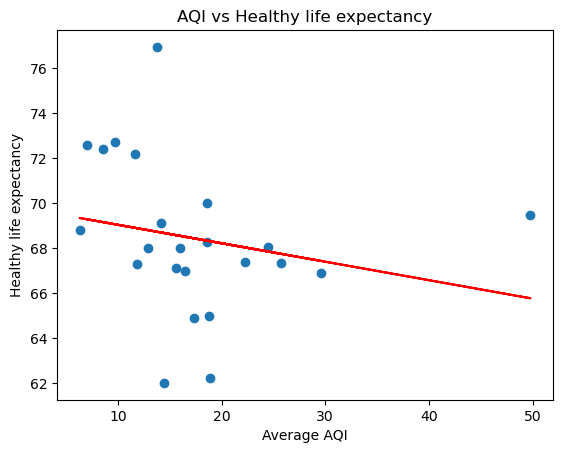

In [16]:
# Create a Scatter plot of AQI vs Healthy life expectancy
merged_df4 = merged_df3.dropna(subset=['Average AQI (2021)'])

plt.scatter(merged_df4['Average AQI (2021)'], merged_df4['Healthy life expectancy'])
plt.xlabel('Average AQI')
plt.ylabel('Healthy life expectancy')
plt.title('AQI vs Healthy life expectancy')

# Create line of best fit
x = merged_df4['Average AQI (2021)']
y = merged_df4['Healthy life expectancy']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')


# Add constant to X array for intercept term
X = sm.add_constant(x)

# Fit linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Get regression statistics
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared
p_value = model.f_pvalue
std_error = model.bse[1]

# Print regression statistics
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared score: {r_squared}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_error}")


plt.show()

Based on the regression statistics, we can see that the slope of the line of best fit is negative (-0.082), indicating that as the average AQI (air quality index) score increases, the healthy life expectancy decreases. However, the R-squared value is quite low (0.048), which suggests that only a small proportion of the variance in healthy life expectancy can be explained by changes in AQI. Additionally, the p-value (0.313) is greater than 0.05, which means that the relationship between AQI and healthy life expectancy may not be statistically significant. Therefore, we cannot definitively conclude that the environment of a country affects their life expectancy based on this analysis alone.

Bar Chart of AQI by Country

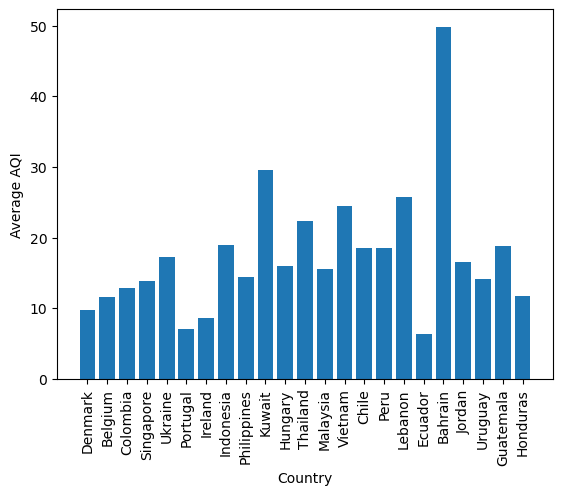

In [17]:
# Bar Chart of AQI by Country
plt.bar(merged_df4['Country'], merged_df4['Average AQI (2021)'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average AQI')
plt.show()

# 2) Do health levels correlate to the level of happiness listed for each country?

In [18]:
#create a a code to determine the correlation between Health Levels and happiness.
correlation = st.pearsonr(whr21_df2["Healthy life expectancy"],whr21_df2["Ladder score"])
print(f"The correlation between Healthy life expectancy and happiness Ladder score is {round(correlation[0],2)}")

The correlation between Healthy life expectancy and happiness Ladder score is 0.77


The r-squared is: 0.59


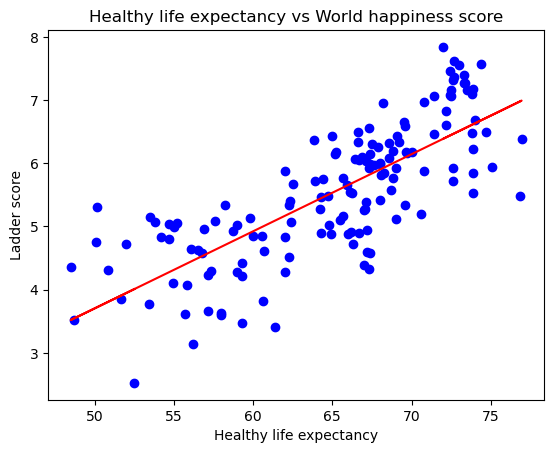

In [19]:
# Create a scatter plot of the positive correlation betwee a healthy life expectancy and happiness

(slope, intercept,rvalue, pvalue, stderr) = st.linregress(whr21_df2["Healthy life expectancy"],whr21_df2["Ladder score"])
regress_values=whr21_df2["Healthy life expectancy"]* slope + intercept
line_eq= f"y = {round(slope, 2)} x + {round(intercept, 2)}"

plt.scatter(whr21_df2["Healthy life expectancy"],whr21_df2["Ladder score"],color='b')
plt.plot(whr21_df2["Healthy life expectancy"], regress_values, color='red')
plt.annotate(line_eq,(2,4), fontsize=13)
plt.xlabel("Healthy life expectancy")
plt.ylabel("Ladder score")
plt.title("Healthy life expectancy vs World happiness score")
print(f"The r-squared is: {round(rvalue**2,3)}")
plt.show()

# 3) Does the amount of gyms per country have any correlation to life expectancy?

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

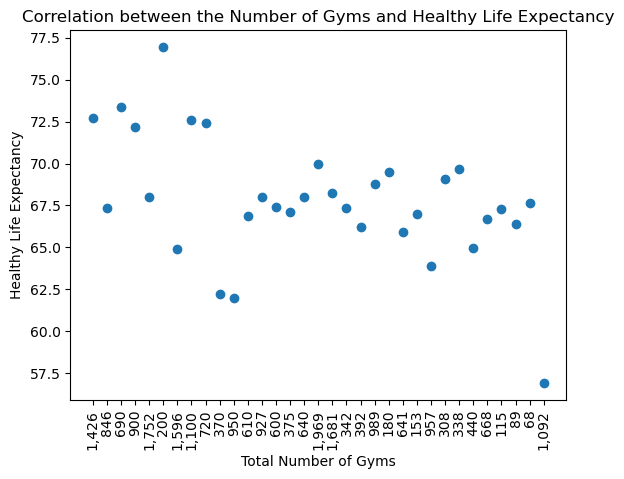

In [20]:
#what is the correlation between life expectancy and number of gyms using a scatter plot 
life_gym = plt.scatter(merged_df3["Total Number of Gyms"],merged_df3["Healthy life expectancy"])


plt.title('Correlation between the Number of Gyms and Healthy Life Expectancy')
plt.xlabel("Total Number of Gyms")
plt.ylabel("Healthy Life Expectancy")
plt.xticks(rotation=90)

<AxesSubplot:xlabel='Total Number of Gyms'>

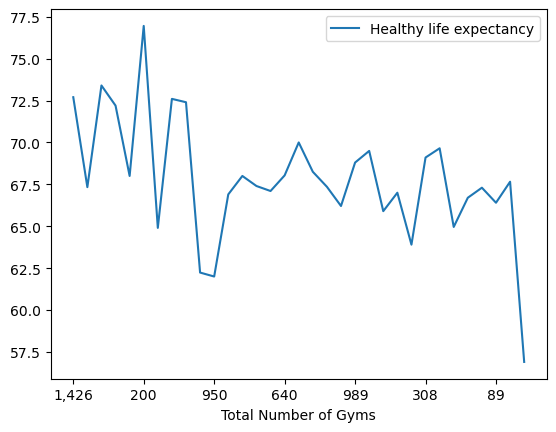

In [21]:
merged_df2.plot('Total Number of Gyms', 'Healthy life expectancy')

# 4) Is the cost of a gym membership prohibitive when compared to GDP per Capita and does that affect Obesity ? 

Regression: GDP per Capita vs. Annual Revenue per Member

Slope: 0.005548012745211769
Intercept: 296.7253816162836
R-squared score: 0.4614873881009735
P-value: 1.38025628128894e-05
Standard error: 0.001076402317725746


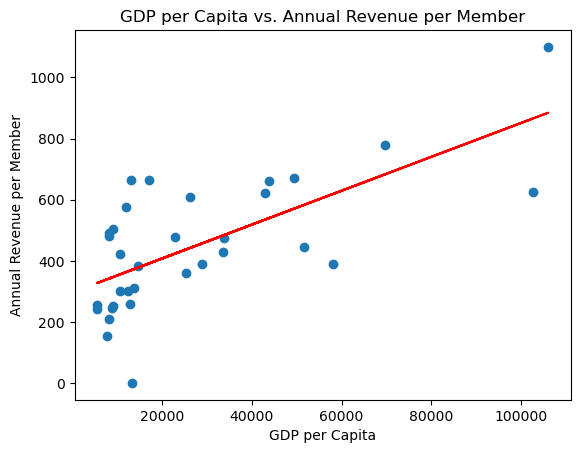

In [22]:
x = merged_df3['Economy: Real GDP per capita']
y = merged_df3['Annual Revenue Per Member']

# Fit a linear regression to the data
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Create a scatter plot of the data
plt.scatter(x, y)

# Plot the regression line
plt.plot(x, slope*x + intercept, color='red')

# Add axis labels and title
plt.xlabel('GDP per Capita')
plt.ylabel('Annual Revenue per Member')
plt.title('GDP per Capita vs. Annual Revenue per Member')

# Print the relevant statistics
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared score: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

# Display the plot
plt.show()

Based on the linear regression results provided, the slope is 0.0055, which indicates that there is a positive relationship between GDP per capita and the annual revenue per member of the gym. The intercept is 296.73, which means that even if the GDP per capita is zero, the expected annual revenue per member of the gym is $296.73.

The R-squared score is 0.46, which means that 46% of the variation in the annual revenue per member can be explained by the variation in GDP per capita.

The p-value is 1.38e-05, which is smaller than the significance level of 0.05, indicating that the slope is statistically significant, and that GDP per capita has a significant effect on the annual revenue per member.

Therefore, based on these results, we can conclude that the cost of a gym membership begins at a fairly prohibitive level when compared to GDP per capita. One would hope that after starting out at a price point of almost $300 per year, the price would stay fairly steady. But to the contrary, as GDP per Capita increases, the price increases at a high rate as well. 

Regression: Healthy life expectancy vs Economy: Real GDP per capita

Slope: 9.501174622525271e-05
Intercept: 65.23182121314176
R-squared score: 0.44321444068667604


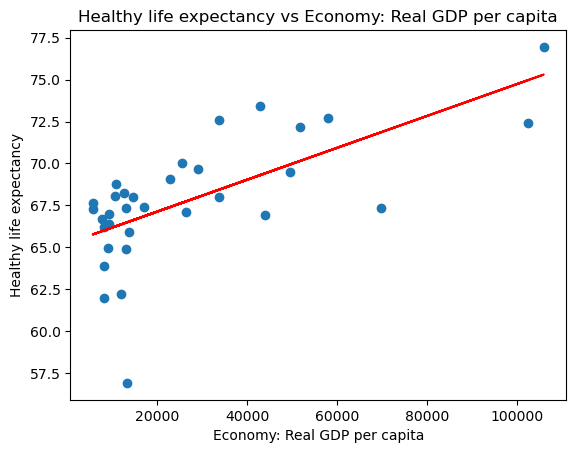

In [23]:
#LINEAR REGRESSION
# Extract the data from the dataframe
x = merged_df3['Economy: Real GDP per capita'].values
y = merged_df3['Healthy life expectancy'].values

# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(x, y, 1)

# Make predictions using the regression line
y_pred = slope * x + intercept

# Calculate the R-squared score
r_squared = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

# Print the results
print('Slope:', slope)
print('Intercept:', intercept)
print('R-squared score:', r_squared)


# Create scatter plot
x = merged_df3['Economy: Real GDP per capita']
y = merged_df3['Healthy life expectancy']
plt.scatter(x, y)

# Add regression line to plot
plt.plot(x, y_pred, color='red')

# Add axis labels and title
plt.xlabel('Economy: Real GDP per capita')
plt.ylabel('Healthy life expectancy')
plt.title('Healthy life expectancy vs Economy: Real GDP per capita')

# Display plot
plt.show()

Based on the findings from the linear regression analysis of healthy life expectancy vs real GDP per capita, the slope of the regression line is 9.501174622525271e-05, indicating that for every unit increase in real GDP per capita, there is an increase of approximately 9.5e-05 units in healthy life expectancy. The intercept of the regression line is 65.23182121314176, meaning that when real GDP per capita is zero, the predicted healthy life expectancy is approximately 65.23 years.

The R-squared score of 0.44321444068667604 suggests that the linear regression model explains approximately 44.3% of the variability in the data. This means that there are other factors that contribute to healthy life expectancy beyond just real GDP per capita.

In conclusion, this analysis suggests that there is a positive relationship between real GDP per capita and healthy life expectancy, but the relationship is not perfect. Other factors such as healthcare, education, and lifestyle choices may also play a role in determining healthy life expectancy. This finding could be useful for policymakers and healthcare professionals to consider when developing strategies to improve public health and well-being.



Regression: GDP per Capita vs. Obesity Rate

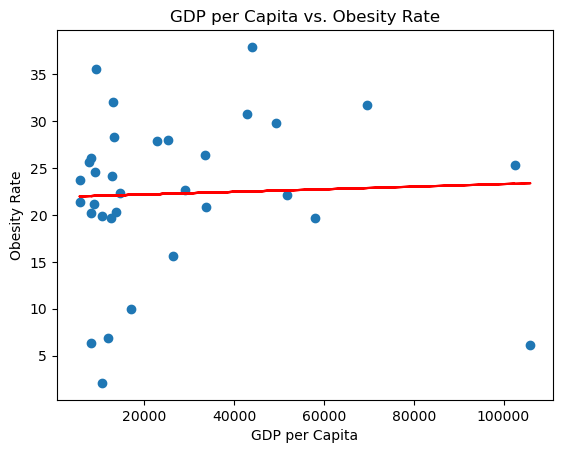

Slope: 1.3887833184138554e-05
Intercept: 21.89884851663493
R-squared score: 0.0018448532977945987
P-value: 0.8123972454287824
Standard error: 5.801920198983484e-05


In [24]:
# Extract the X and Y values from your data
x = merged_df3['Economy: Real GDP per capita']
y = merged_df3['Obesity Rate in Adults (2016)']

# Fit a linear regression to the data
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Create a scatter plot of the data
plt.scatter(x, y)

# Plot the regression line
plt.plot(x, intercept + slope*x, color='red')

# Add axis labels and title
plt.xlabel('GDP per Capita')
plt.ylabel('Obesity Rate')
plt.title('GDP per Capita vs. Obesity Rate')

# Display the plot
plt.show()

# Print the statistics
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared score:", r_value**2)
print("P-value:", p_value)
print("Standard error:", std_err)

Based on the findings from the linear regression analysis of GDP per Capita vs. Obesity Rate, the slope of the regression line indicates that for every unit increase in GDP per Capita, there is an increase of approximately 1.39e-05 units in Obesity Rate. The intercept of the regression line is 21.89, meaning that when GDP per Capita is zero, the predicted Obesity Rate is approximately 21.90%.

The R-squared score of 0.0018 suggests that the linear regression model explains only approximately 0.18% of the variability in the data. This means that GDP per Capita is not a strong predictor of Obesity Rate.

The P-value of 0.8123972454287824 suggests that the slope of the regression line is not statistically significant at the 5% level. This means that there is insufficient evidence to reject the null hypothesis that the slope is equal to zero.

In conclusion, this analysis suggests that there is a weak and statistically insignificant relationship between GDP per Capita and Obesity Rate. Other factors such as cultural and dietary habits, lifestyle choices, and healthcare accessibility may play a more significant role in determining Obesity Rate. This finding could be useful for policymakers and healthcare professionals to consider when developing strategies to address the issue of obesity.

# 5) Does having a higher number of hours worked effect happiness/gym availability/obesity levels?

In [25]:
# create df showcasing Country, Members per Gym, Work happiness Score and Obesity rate in adults.
merged_df5 = merged_df3[["Country", "Members Per Gym","World Happiness Score","Obesity Rate in Adults (2016)"]]

merged_df5

,Country,Members Per Gym,World Happiness Score,Obesity Rate in Adults (2016)
0,Denmark,769.985975,7.620,19.7
1,United Arab Emirates,635.121749,6.561,31.7
2,New Zealand,942.028985,7.277,30.8
3,Belgium,980.000000,6.834,22.1
4,Colombia,558.789954,6.012,22.3
5,Singapore,1600.000000,6.377,6.1
6,Ukraine,795.739348,4.875,24.1
7,Portugal,625.454545,5.929,20.8
8,Ireland,715.277778,7.085,25.3
9,Indonesia,1270.270270,5.345,6.9


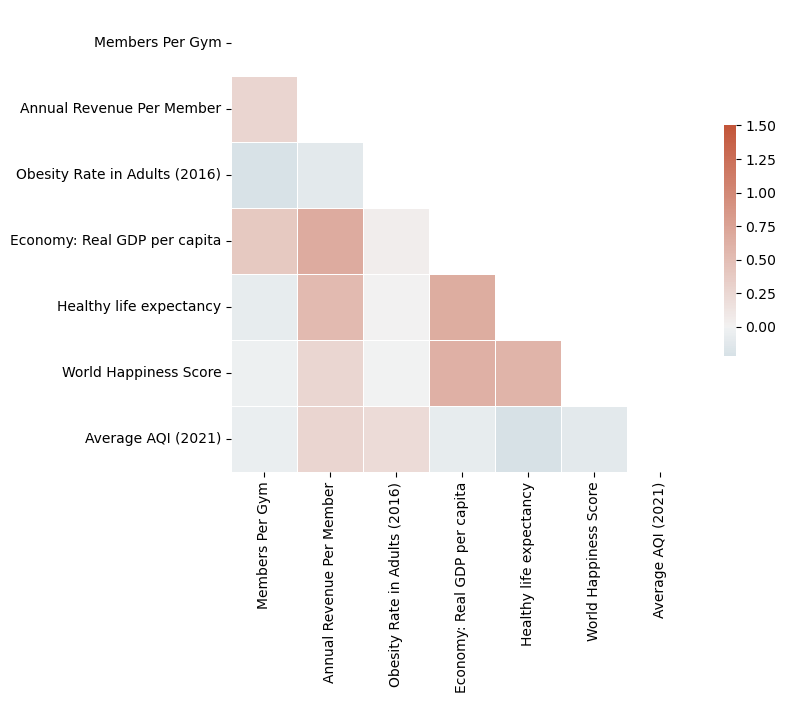

In [26]:
# Create Visualization 5) Does having a higher number of obesity levels  affect happiness, and gym availability?

# Create a sample dataset with 5 columns
pulled_data = pd.DataFrame(np.random.randn(100, 4), columns=["Country", "World Happiness Score", 
                                                             "Obesity Rate in Adults (2016)", "Total Members"])


# Compute the correlation matrix
corr = merged_df3.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax= 1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show the plot
plt.show()
